# Time series


La libreria `siphon` viene con un servicio de consulta especializado para series temporales.

In [1]:

from siphon.catalog import TDSCatalog

In [2]:
# si el catalogo que se desea es de 0.25 grados
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

# lista de colecciones
print(best_gfs.datasets)

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [3]:
best_ds = list(best_gfs.datasets.values())[1]

# diccionario de urls disponibles con la información
best_ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'JupyterNotebook': 'https://thredds.ucar.edu/thredds/notebook/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grid/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best'}

In [4]:
best_ds = best_gfs.datasets[0]
ncss =best_ds.subset()
query = ncss.query()

Requerimiento de datos, para eso recurrimos a la función `query.lonlat_pint()`

In [5]:
from datetime import datetime, timedelta, timezone

now = datetime.now(timezone.utc)
# buscando la posición de lima
query.lonlat_point(-77, -12).vertical_level(100000).time_range(now, now + timedelta(days=30))
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric')

# haciendo el requerimiento de los datos
data = ncss.get_data(query)

In [6]:
temp = data.variables['Temperature_isobaric']
relh = data.variables['Relative_humidity_isobaric']
tiempo = data.variables['time']

In [7]:
import numpy as np
from netCDF4 import num2date

# tenemos que ayudarnos con el numpy.array para trabajar con estos datos
time_vals = np.array(num2date(tiempo[:].squeeze(), tiempo.units), dtype='datetime64[s]')
time_vals[:5]

array(['2022-10-24T21:00:00', '2022-10-25T00:00:00',
       '2022-10-25T03:00:00', '2022-10-25T06:00:00',
       '2022-10-25T09:00:00'], dtype='datetime64[s]')

Vamos a dejar nuestros datos mas fáciles de manipular, utilizaremos el `xarray.backends`

> recuerda que los datos que vamos a utlizar son los que vienen del `data = ncss.get_data(query)`

In [8]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data_2 = xr.open_dataset(NetCDF4DataStore(data))
list(data.variables.keys())

['latitude',
 'longitude',
 'stationAltitude',
 'station_id',
 'station_description',
 'time',
 'stationIndex',
 'Temperature_isobaric',
 'Relative_humidity_isobaric']

## Plot normal

/tmp/ipykernel_7877/1729086785.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


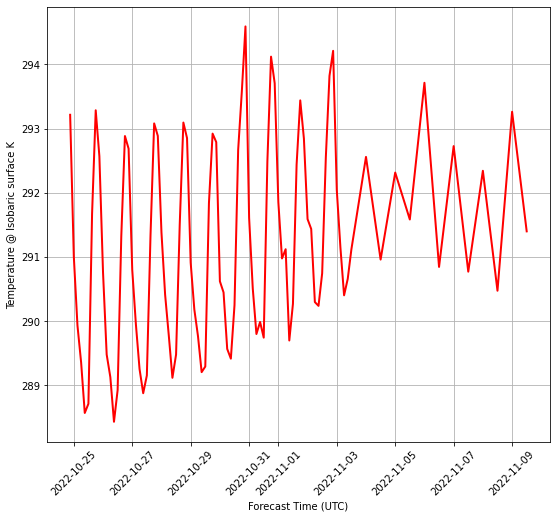

In [9]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(f'{temp.long_name} {temp.units}')
ax.set_xlabel('Forecast Time (UTC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(True)

/tmp/ipykernel_7877/528398502.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


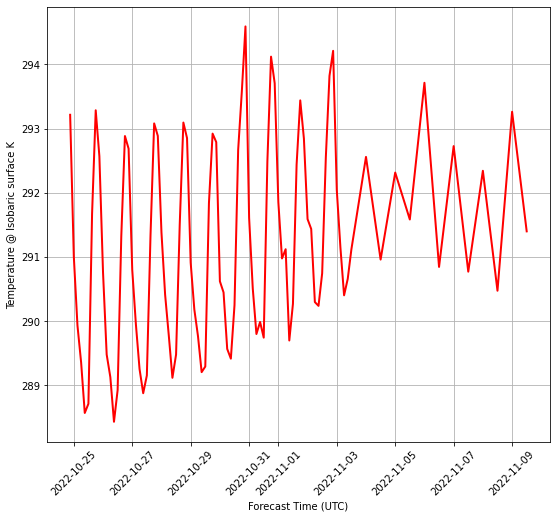

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(data_2.time, data_2.Temperature_isobaric, 'r', linewidth=2)
ax.set_ylabel(f'{data_2.Temperature_isobaric.long_name} {data_2.Temperature_isobaric.units}')
ax.set_xlabel('Forecast Time (UTC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(True)

## Plot mejorado

Vamos a utilizar la base disponibilizada por el `geocat-viz` para [manipular los ejes](https://geocat-examples.readthedocs.io/en/latest/gallery/XY/NCL_tm_2.html#sphx-glr-gallery-xy-ncl-tm-2-py)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import geocat.viz as gv


In [12]:
tiempo

<class 'netCDF4._netCDF4.Variable'>
float64 time(obs)
    units: Hour since 2022-10-24T12:00:00Z
    long_name: time of measurement
    calendar: proleptic_gregorian
unlimited dimensions: obs
current shape = (90,)
filling off

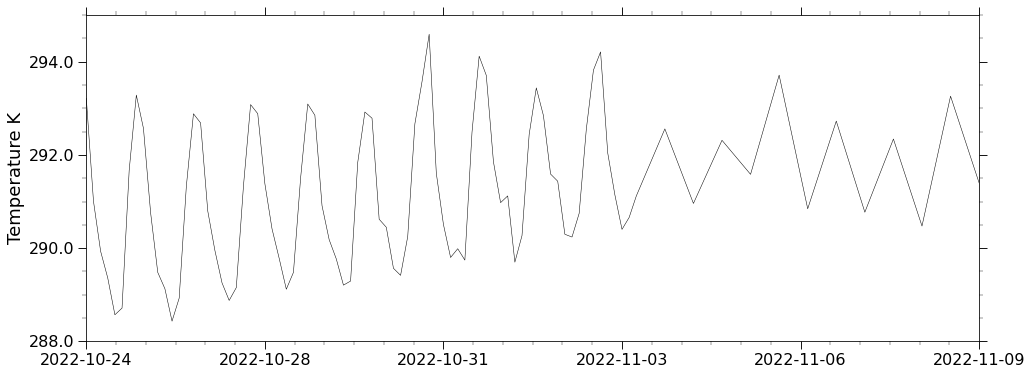

In [63]:
# vamos a utilizar el pandas para tener mas control del tiempo
from matplotlib.pyplot import ylabel
import pandas as pd
fechas = pd.to_datetime(data_2.time)

# Generate figure and set its size (width, height)
plt.figure(1, figsize=(16, 6))
ax = plt.gca()

# Format the tick labels.
# For the minor ticks, use no labels; defaults to NullFormatter.
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.plot(fechas, data_2.Temperature_isobaric, color='black', linewidth=0.5)

gv.add_major_minor_ticks(ax,
                             x_minor_per_major=5,  # número de divisiones entre marcadores principales
                             y_minor_per_major=3,
                             labelsize=14)
# Add minor and major tick lines for plot 3
gv.add_major_minor_ticks(ax,
                         x_minor_per_major=6,
                         y_minor_per_major=4,
                         labelsize=16)

gv.set_axes_limits_and_ticks(ax,
                             xlim=(fechas.min(), fechas.max()),
                             ylim=(288, 295),
                             xticks=pd.date_range(fechas.min(), fechas.max(), 6),
                             xticklabels=pd.date_range(fechas.min(), fechas.max(), 6).date,
                             yticks=np.arange(284, 296, 2))
ax.set_ylabel('Temperature [K]', size=18)

plt.show()

## Retornar al [indice](./../indice.md)